# Kaggle Instacart dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from functools import partial
import gc
%matplotlib inline

## Product data

In [2]:
aisles = pd.read_csv("./aisles.csv", engine='c')
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [3]:
departments = pd.read_csv('./departments.csv', engine='c')
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [4]:
products = pd.read_csv('./products.csv', engine='c')
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [5]:
products = pd.merge(products, aisles, on='aisle_id', how='left')
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle  
0             19               cookies cakes  
1             13           spices seasonings  
2              7                         tea  
3              1                frozen meals  
4             13  marinades meat preparation

In [6]:
products = pd.merge(products, departments, on='department_id', how='left')
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry

## Order data

Use explicit typing and the C engine so that pandas doesn't have to make expensive type inferences

In [7]:
op_train = pd.read_csv('./order_products__train.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
op_train.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [8]:
op_prior = pd.read_csv('./order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
op_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [9]:
orders = pd.read_csv('./orders.csv', engine='c', dtype={'order_id': np.int32, 
                                                           'user_id': np.int32, 
                                                           'order_number': np.int32, 
                                                           'order_dow': np.int8, 
                                                           'order_hour_of_day': np.int8, 
                                                           'days_since_prior_order': np.float16})
orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.int8)

orders = orders[orders['eval_set'].isin([0, 1])]
orders.head()

order_id  user_id  eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1         0             1          2                  8   
1   2398795        1         0             2          3                  7   
2    473747        1         0             3          3                 12   
3   2254736        1         0             4          4                  7   
4    431534        1         0             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

### Train set is split into capstone-train and capstone-test

The `train` set is split into `capstone-train` and `capstone-test` by `user_id` (so a user is in one set or the other, but not both).

Two additional files enumerate the users to be used in your model training set vs evaluation set for submission.

In [10]:
train_user_ids = pd.read_csv('./capstone-train-user_ids.csv', engine='c')
train_user_ids.columns = ['user_id']

In [11]:
test_user_ids = pd.read_csv('./capstone-test-user_ids.csv', engine='c')
test_user_ids.columns = ['user_id']

### Get only train orders and split into test/train

Change 'eval_set' to 2 for the test users, but don't change the "prior" orders for those test users.

In [12]:
tr_orders = orders[orders['eval_set'] == 1]
tr_orders = tr_orders[tr_orders['user_id'].isin(test_user_ids['user_id'])]
tr_orders.loc[:, 'eval_set'] = 2
tr_orders.head()

order_id  user_id  eval_set  order_number  order_dow  order_hour_of_day  \
74     525192        7         2            21          2                 11   
129   2316178       14         2            14          2                 19   
200   2180313       17         2            41          3                 10   
277   3402036       23         2             5          1                 12   
395   2614670       27         2            82          5                 14   

     days_since_prior_order  
74                      6.0  
129                    11.0  
200                    30.0  
277                    30.0  
395                     4.0

In [13]:
orders.loc[orders.order_id.isin(tr_orders['order_id']), 'eval_set'] = 2
del tr_orders
gc.collect()

29

In [14]:
orders[orders['eval_set'] == 2].head()

order_id  user_id  eval_set  order_number  order_dow  order_hour_of_day  \
74     525192        7         2            21          2                 11   
129   2316178       14         2            14          2                 19   
200   2180313       17         2            41          3                 10   
277   3402036       23         2             5          1                 12   
395   2614670       27         2            82          5                 14   

     days_since_prior_order  
74                      6.0  
129                    11.0  
200                    30.0  
277                    30.0  
395                     4.0

In [15]:
train_orders = orders[orders['eval_set'] == 1]
test_orders = orders[orders['eval_set'] == 2]

In [16]:
#op_test = op_train[op_train['order_id'].isin(test_orders['order_id'])]
#op_train = op_train[op_train['order_id'].isin(train_orders['order_id'])]

In [17]:
#op_train.head(4)

In [18]:
#op_test.head(4)

### Exploratory analysis

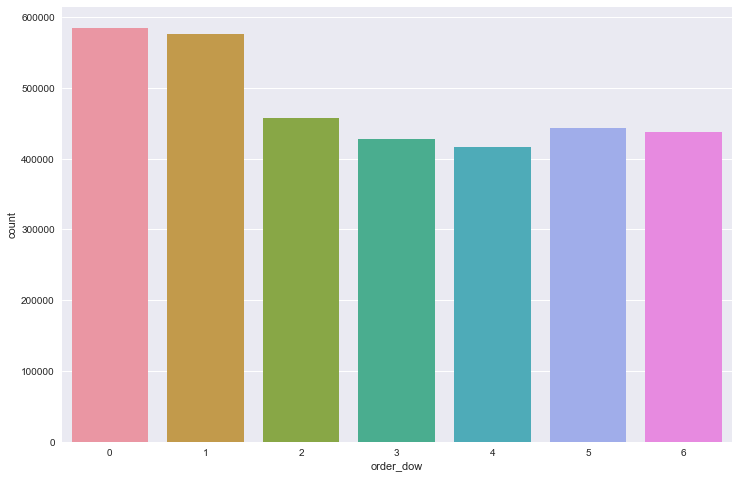

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
seaborn.countplot(x="order_dow", data=orders)

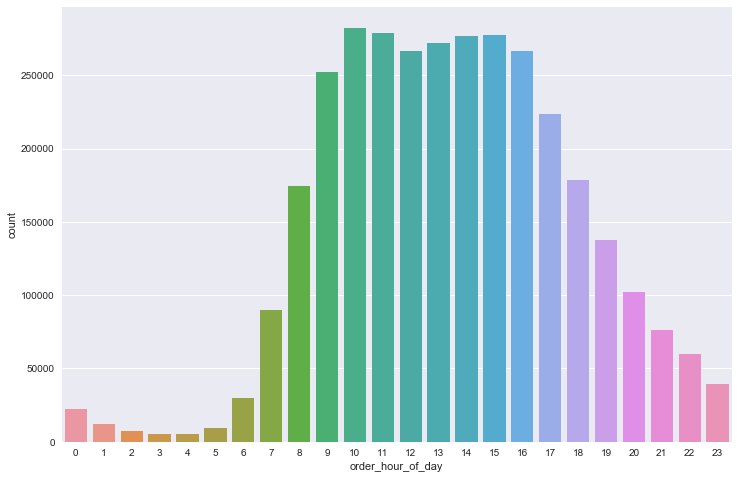

In [20]:
fig, ax = plt.subplots(figsize = (12,8))
seaborn.countplot(x="order_hour_of_day", data=orders)

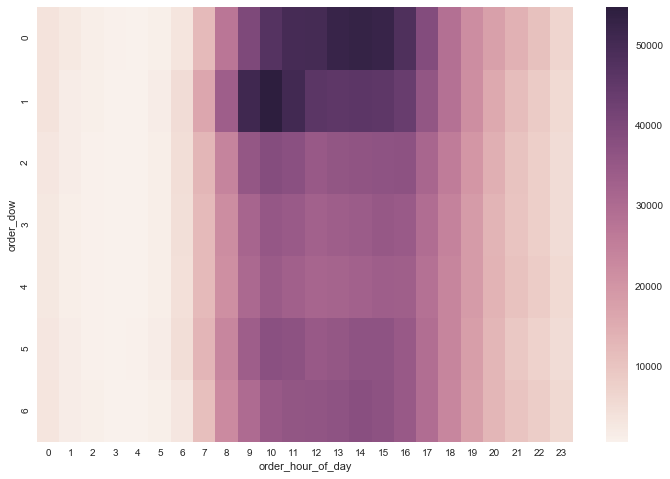

In [21]:
hm_data = orders.groupby(["order_dow", "order_hour_of_day"])["order_id"].aggregate("count").reset_index()
hm_data = hm_data.pivot('order_dow', 'order_hour_of_day', 'order_id')

fig, ax = plt.subplots(figsize = (12,8))
seaborn.heatmap(hm_data)

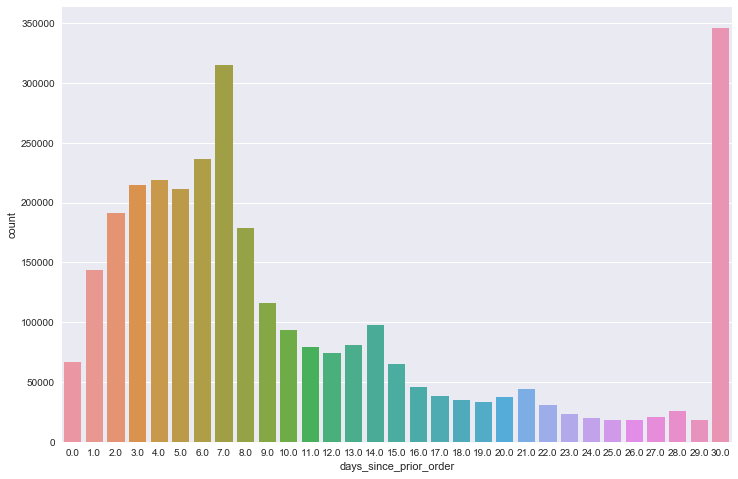

In [22]:
del hm_data
gc.collect()

fig, ax = plt.subplots(figsize = (12,8))
seaborn.countplot(x="days_since_prior_order", data=orders)

## Combine into one DataFrame

credit: https://www.kaggle.com/frednavruzov/dumb-and-the-dumber-baselines-plb-0-3276826

In [23]:
indexes = np.linspace(0, len(op_prior), num=10, dtype=np.int32)

order_details = pd.merge(op_train, orders, how='left', on='order_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

order_details = pd.merge(order_details, products[['product_id', 'aisle_id', 'department_id']].apply(partial(pd.to_numeric, errors='ignore', downcast='integer')), how='left', on='product_id')

print(order_details.shape, op_train.shape)

del op_train

order_details.head()

((1384617, 12), (1384617, 4))


order_id  product_id  add_to_cart_order  reordered  user_id  eval_set  \
0         1       49302                  1          1   112108         1   
1         1       11109                  2          1   112108         1   
2         1       10246                  3          0   112108         1   
3         1       49683                  4          0   112108         1   
4         1       43633                  5          1   112108         1   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                       9   
1             4          4                 10                       9   
2             4          4                 10                       9   
3             4          4                 10                       9   
4             4          4                 10                       9   

   aisle_id  department_id  
0       120             16  
1       108             16  
2        83              4  
3        83              4  
4        95             15

In [24]:
%%time
# update by small portions
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=op_prior.loc[indexes[i]:indexes[i+1], :],
                            right=products[['product_id', 
                                         'aisle_id', 
                                         'department_id' ]].apply(partial(pd.to_numeric, 
                                                                          errors='ignore', 
                                                                          downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders, 
                     how='left', 
                     on='order_id'
                ) #.apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
        ]
    )
        
print('Dataframe length: {}'.format(order_details.shape[0]))
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, 
                                                                         deep=True) / 2**20)))
# check dtypes to see if we use memory effectively
print(order_details.dtypes)

# delete (redundant now) dataframes
del op_prior, orders

gc.collect()

Dataframe length: 33819114
Memory consumption: 1128.83 Mb
add_to_cart_order           int16
aisle_id                    int16
days_since_prior_order    float16
department_id                int8
eval_set                     int8
order_dow                    int8
order_hour_of_day            int8
order_id                    int32
order_number                int32
product_id                  int32
reordered                    int8
user_id                     int32
dtype: object
Wall time: 33 s


## Product Features

In [25]:
#prods = pd.DataFrame()
prods = order_details.groupby('product_id').size().astype(np.int32).to_frame('num_orders')
prods['num_reorders'] = order_details[order_details['reordered'] == 1].groupby('product_id').size().astype(np.int32)
prods['avg_pos'] = order_details.groupby('product_id')['add_to_cart_order'].mean().astype(np.int32)
prods['avg_days_since'] = order_details.groupby('product_id')['days_since_prior_order'].mean()
prods.reset_index(inplace=True)

In [26]:
prods.head()

product_id  num_orders  num_reorders  avg_pos  avg_days_since
0           1        1928        1185.0        5       10.710938
1           2          94          13.0       10       10.492188
2           3         283         209.0        6       10.796875
3           4         351         161.0        9       14.867188
4           5          16          10.0        6       13.000000

In [27]:
users = order_details.groupby('user_id').size().astype(np.int16).to_frame('num_user_ords')
users['num_user_reorders'] = order_details[order_details['reordered'] == 1].groupby('user_id').size().astype(np.int16)
users.reset_index(inplace=True)

In [28]:
users.head()

user_id  num_user_ords  num_user_reorders
0        1             70               51.0
1        2            226              105.0
2        3             88               55.0
3        4             18                1.0
4        5             46               18.0

In [29]:
user_prods = order_details.groupby(['user_id', 'product_id']).size().astype(np.int32).to_frame('num_up_orders')
user_prods['num_up_reorders'] = order_details[order_details['reordered'] == 1].groupby(['user_id', 'product_id']).size().astype(np.int32)
user_prods['avg_up_pos'] = order_details.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().astype(np.int32)
user_prods['avg_up_days_since'] = order_details.groupby(['user_id', 'product_id'])['days_since_prior_order'].mean()
user_prods['up_first_order'] = order_details.groupby(['user_id', 'product_id'])['order_number'].min().astype(np.int32)
user_prods['up_last_order'] = order_details.groupby(['user_id', 'product_id'])['order_number'].max().astype(np.int32)
user_prods.reset_index(inplace=True)

In [30]:
user_prods.head()

user_id  product_id  num_up_orders  num_up_reorders  avg_up_pos  \
0        1         196             11             10.0           1   
1        1       10258             10              9.0           3   
2        1       10326              1              NaN           5   
3        1       12427             10              9.0           3   
4        1       13032              4              3.0           6   

   avg_up_days_since  up_first_order  up_last_order  
0            19.0000               1             11  
1            19.0000               2             11  
2            28.0000               5              5  
3            19.5625               1             10  
4            19.7500               2             11

In [31]:
prods.columns

Index([u'product_id', u'num_orders', u'num_reorders', u'avg_pos',
       u'avg_days_since'],
      dtype='object')

In [32]:
users.columns

Index([u'user_id', u'num_user_ords', u'num_user_reorders'], dtype='object')

In [33]:
user_prods.columns

Index([u'user_id', u'product_id', u'num_up_orders', u'num_up_reorders',
       u'avg_up_pos', u'avg_up_days_since', u'up_first_order',
       u'up_last_order'],
      dtype='object')

In [34]:
user_prods = user_prods.merge(users, on='user_id')
user_prods = user_prods.merge(prods, on='product_id')

del users
del prods
gc.collect()

115

In [35]:
user_prods['up_order_rate'] = user_prods['num_up_orders'] / user_prods['num_user_ords']
user_prods['orders_since_last_up_order'] = user_prods['num_user_ords'] - user_prods['up_last_order']

In [36]:
order_details = order_details.merge(user_prods, on=['user_id', 'product_id'])

del user_prods
gc.collect()

49

In [37]:
print(order_details.dtypes)
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, 
                                                                         deep=True) / 2**20)))

add_to_cart_order               int16
aisle_id                        int16
days_since_prior_order        float16
department_id                    int8
eval_set                         int8
order_dow                        int8
order_hour_of_day                int8
order_id                        int32
order_number                    int32
product_id                      int32
reordered                        int8
user_id                         int32
num_up_orders                   int32
num_up_reorders               float64
avg_up_pos                      int32
avg_up_days_since             float16
up_first_order                  int32
up_last_order                   int32
num_user_ords                   int16
num_user_reorders             float64
num_orders                      int32
num_reorders                  float64
avg_pos                         int32
avg_days_since                float16
up_order_rate                 float64
orders_since_last_up_order      int32
dtype: objec

In [39]:
order_details['reordered'].fillna(0, inplace=True)
order_details['reordered'] = order_details['reordered'].astype(np.uint8)
gc.collect()

9

In [40]:
train = order_details[order_details['eval_set'] == 1].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)
test = order_details[order_details['eval_set'] == 2].drop(['eval_set', 'user_id', 'reordered'], axis=1)

del order_details
gc.collect()

14

In [41]:
train.head()

add_to_cart_order  aisle_id  days_since_prior_order  department_id  \
0                  1       120                     9.0             16   
3                  2       108                     9.0             16   
6                  3        83                     9.0              4   
7                  4        83                     9.0              4   
8                  5        95                     9.0             15   

   order_dow  order_hour_of_day  order_number  reordered  num_up_orders  \
0          4                 10             4          1              3   
3          4                 10             4          1              3   
6          4                 10             4          0              1   
7          4                 10             4          0              1   
8          4                 10             4          1              3   

   num_up_reorders             ...              up_first_order  up_last_order  \
0              2.0             ...                           1              4   
3              2.0             ...                           1              4   
6              NaN             ...                           4              4   
7              NaN             ...                           4              4   
8              2.0             ...                           1              4   

   num_user_ords  num_user_reorders  num_orders  num_reorders  avg_pos  \
0             29               13.0         171         108.0        6   
3             29               13.0        4616        3299.0        7   
6             29               13.0       24888       13067.0        9   
7             29               13.0       99728       69022.0        7   
8             29               13.0         677         322.0        9   

   avg_days_since  up_order_rate  orders_since_last_up_order  
0       10.125000       0.103448                          25  
3       10.796875       0.103448                          25  
6       11.085938       0.034483                          25  
7       12.320312       0.034483                          25  
8       12.000000       0.103448                          25  

[5 rows x 22 columns]

In [42]:
test.head()

add_to_cart_order  aisle_id  days_since_prior_order  department_id  \
47                  1       117                    24.0             19   
48                  2       123                    24.0              4   
49                  3        19                    24.0             13   
50                  4       123                    24.0              4   
52                  5        83                    24.0              4   

    order_dow  order_hour_of_day  order_id  order_number  product_id  \
47          6                 16        38             6       11913   
48          6                 16        38             6       18159   
49          6                 16        38             6        4461   
50          6                 16        38             6       21616   
52          6                 16        38             6       23622   

    num_up_orders             ...              up_first_order  up_last_order  \
47              1             ...                           6              6   
48              1             ...                           6              6   
49              1             ...                           6              6   
50              2             ...                           1              6   
52              1             ...                           6              6   

    num_user_ords  num_user_reorders  num_orders  num_reorders  avg_pos  \
47             48                9.0        2048        1067.0        8   
48             48                9.0        4565        2332.0        9   
49             48                9.0        8815        2288.0        9   
50             48                9.0       75752       51869.0        8   
52             48                9.0        7894        3424.0        9   

    avg_days_since  up_order_rate  orders_since_last_up_order  
47       10.640625       0.020833                          42  
48       11.117188       0.020833                          42  
49       11.468750       0.020833                          42  
50       11.523438       0.041667                          42  
52       10.367188       0.020833                          42  

[5 rows x 23 columns]

In [112]:
train = train.astype(dtype= {'aisle_id': np.uint8, 'days_since_prior_order': np.float16, 'order_number': np.uint16,
                             'num_up_orders': np.uint8, 'num_up_reorders': np.float16, 'avg_up_pos': np.uint8, 
                             'avg_up_days_since': np.float16, 'up_first_order': np.uint8, 'up_last_order': np.uint8,
                             'num_user_ords': np.uint8, 'num_user_reorders': np.float16, 'num_orders': np.uint16,
                             'num_reorders': np.float16, 'avg_pos': np.uint8, 'avg_days_since': np.float16,
                             'up_order_rate': np.float16, 'orders_since_last_up_order': np.uint8}, copy=False)

test = test.astype(dtype= {'aisle_id': np.uint8, 'days_since_prior_order': np.float16, 'order_number': np.uint16,
                             'num_up_orders': np.uint8, 'num_up_reorders': np.float16, 'avg_up_pos': np.uint8, 
                             'avg_up_days_since': np.float16, 'up_first_order': np.uint8, 'up_last_order': np.uint8,
                             'num_user_ords': np.uint8, 'num_user_reorders': np.float16, 'num_orders': np.uint16,
                             'num_reorders': np.float16, 'avg_pos': np.uint8, 'avg_days_since': np.float16,
                             'up_order_rate': np.float16, 'orders_since_last_up_order': np.uint8}, copy=False)


In [113]:
train = train.fillna(0)
test = test.fillna(0)

In [114]:
train.dtypes

add_to_cart_order               int16
aisle_id                        uint8
days_since_prior_order        float16
department_id                    int8
order_dow                        int8
order_hour_of_day                int8
order_number                   uint16
reordered                       uint8
num_up_orders                   uint8
num_up_reorders               float16
avg_up_pos                      uint8
avg_up_days_since             float16
up_first_order                  uint8
up_last_order                   uint8
num_user_ords                   uint8
num_user_reorders             float16
num_orders                     uint16
num_reorders                  float16
avg_pos                         uint8
avg_days_since                float16
up_order_rate                 float16
orders_since_last_up_order      uint8
dtype: object

In [120]:
train.replace([np.inf, -np.inf], np.nan)
train.fillna(0, inplace=True)

test.replace(np.finfo(np.float64).max, np.nan)
test.fillna(0, inplace=True)

In [123]:
train = train.drop('num_reorders', axis=1)
test = test.drop('num_reorders', axis=1)

In [124]:
X_train = train[train.columns.difference(['reordered'])]
y_train = train['reordered']

X_train.isnull().values.any()

False

In [127]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_features=5).fit(X_train, y_train)

In [128]:
test['reordered'] = clf.predict(test[test.columns.difference(['order_id', 'product_id'])])

In [130]:
d = dict()
for row in test.itertuples():
    if row.reordered == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)
            
for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

In [136]:
submission = pd.DataFrame.from_dict(d, orient='index')
submission.reset_index(inplace=True)

In [137]:
submission.columns = ['order_id', 'products']

In [138]:
submission.to_csv('submission.csv', index=False)

In [139]:
clf.feature_importances_

array([  2.51538747e-04,   1.25064173e-07,   2.35740136e-07,
         4.49720187e-04,   2.48857862e-02,   6.12293717e-04,
         1.00962965e-03,   9.12374928e-08,   5.54036709e-04,
         4.51380677e-01,   3.64882061e-01,   6.16604038e-03,
         1.43343735e-02,   4.48143631e-08,   2.19914672e-07,
         9.45172442e-03,   4.32287113e-03,   8.44728816e-02,
         4.75361021e-03,   3.24720385e-02])

In [140]:
train.columns

Index([u'add_to_cart_order', u'aisle_id', u'days_since_prior_order',
       u'department_id', u'order_dow', u'order_hour_of_day', u'order_number',
       u'reordered', u'num_up_orders', u'num_up_reorders', u'avg_up_pos',
       u'avg_up_days_since', u'up_first_order', u'up_last_order',
       u'num_user_ords', u'num_user_reorders', u'num_orders', u'avg_pos',
       u'avg_days_since', u'up_order_rate', u'orders_since_last_up_order'],
      dtype='object')

In [153]:
zip(train.columns, clf.feature_importances_)

[('add_to_cart_order', 0.00025153874657091256),
 ('aisle_id', 1.2506417325572942e-07),
 ('days_since_prior_order', 2.3574013608022517e-07),
 ('department_id', 0.00044972018653027226),
 ('order_dow', 0.024885786207272262),
 ('order_hour_of_day', 0.00061229371748855704),
 ('order_number', 0.0010096296514556157),
 ('reordered', 9.1237492811695272e-08),
 ('num_up_orders', 0.00055403670880390136),
 ('num_up_reorders', 0.45138067680434246),
 ('avg_up_pos', 0.36488206148630392),
 ('avg_up_days_since', 0.0061660403843464325),
 ('up_first_order', 0.014334373528944839),
 ('up_last_order', 4.4814363065767807e-08),
 ('num_user_ords', 2.1991467188917733e-07),
 ('num_user_reorders', 0.0094517244211388823),
 ('num_orders', 0.0043228711263799428),
 ('avg_pos', 0.08447288156494924),
 ('avg_days_since', 0.004753610208109881),
 ('up_order_rate', 0.032472038486525696)]